# Algorithmic Trading Model for Simple Moving Average Crossover Grid Search
### David Lowe
### June 16, 2020

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: The purpose of this project is to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This algorithmic trading model examines a series of simple moving average (MA) models via a grid search methodology. When the fast moving-average curve crosses above the slow moving-average curve, the strategy goes long (buys) on the stock. When the opposite occurs, we will exit the position.

The grid search methodology will search through all combinations between the two MA curves. The faster MA curve can range from 5 days to 20 days, while the slower MA can range from 10 days to 50 days. Both curves use a 5-day increment. We will apply the analysis on the AMZN stock for the trading period between 2019-1-1 to 2020-06-15.

ANALYSIS: In this iteration, the top model of 20-day/50-day returned a net profit of <span class="tex2jax_ignore">$</span>839.07. In the meantime, the long-only approach achieved an accumulated return of 1,079.82.

CONCLUSION: For this trading period, the trading strategy deployed using the SMA model failed to outperform the more straightforward long-only path. We should consider doing more modeling and more back-testing to validate the approach we wish to apply to the future trading period.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Develop Strategy and Train Model
4. Back-test Model
5. Evaluate Performance

## Task 1. Prepare Environment

In [1]:
import os
import sys
import smtplib
import numpy as np
import pandas as pd
import requests
import json
from email.message import EmailMessage
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import load_dotenv

In [2]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = False

# Set up the sendNotification flag to send progress emails (setting True will send emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", 120)
pd.set_option("display.width", 140)

In [3]:
stock_symbol = 'AMZN'
initial_capital = 0

# Specify the parameters for the trading strategy
fast_ma_min = 5
fast_ma_max = 20
slow_ma_min = 10
slow_ma_max = 50
ma_increment = 5
min_ma_gap = 5

model_start_date = datetime(2019, 1, 1)
print("Starting date for the model:", model_start_date)
stock_start_date = model_start_date - timedelta(days=int(slow_ma_max*1.5)) # Need more pricing data to calculate moving averages

# model_end_date = datetime(2020, 1, 1)
model_end_date = datetime.now()
print("Ending date for the model:", model_end_date)

Starting date for the model: 2019-01-01 00:00:00
Ending date for the model: 2020-06-13 17:57:28.728685


## Task 2. Acquire and Pre-Process Data

In [4]:
# Check and see whether the API key is available
quandl_key = os.environ.get('QUANDL_API')
if quandl_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

In [5]:
start_date_string = stock_start_date.strftime('%Y-%m-%d')
end_date_string = model_end_date.strftime('%Y-%m-%d')

quandl_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, stock_symbol, quandl_key)

In [6]:
response = requests.get(quandl_url)
quandl_dict = json.loads(response.text)
stock_quandl = pd.DataFrame(quandl_dict['datatable']['data'])
print(len(stock_quandl), 'data points retrieved from the API call.')
if verbose: print(quandl_dict)

415 data points retrieved from the API call.


In [7]:
stock_quandl.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
# stock_quandl.set_index('date', inplace=True)
stock_quandl.index = pd.to_datetime(stock_quandl.date)
stock_quandl = stock_quandl.sort_index(ascending = True)
stock_quandl.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 415 entries, 2018-10-18 to 2020-06-12
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ticker       415 non-null    object 
 1   date         415 non-null    object 
 2   open         415 non-null    float64
 3   high         415 non-null    float64
 4   low          415 non-null    float64
 5   close        415 non-null    float64
 6   volume       415 non-null    float64
 7   dividend     415 non-null    float64
 8   closeunadj   415 non-null    float64
 9   lastupdated  415 non-null    object 
dtypes: float64(7), object(3)
memory usage: 35.7+ KB


In [8]:
stock_quandl.head()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2018-10-18,AMZN,2018-10-18,1821.49,1830.15,1767.87,1770.72,5873995.0,0.0,1770.72,2020-05-01
2018-10-19,AMZN,2018-10-19,1785.16,1809.10,1753.00,1764.03,5907246.0,0.0,1764.03,2020-05-01
2018-10-22,AMZN,2018-10-22,1784.00,1809.50,1756.00,1789.30,4500015.0,0.0,1789.30,2020-05-01
2018-10-23,AMZN,2018-10-23,1742.24,1776.34,1714.00,1768.70,6723913.0,0.0,1768.70,2020-05-01
2018-10-24,AMZN,2018-10-24,1773.70,1777.71,1656.56,1664.20,6928383.0,0.0,1664.20,2020-05-01


In [9]:
stock_quandl.tail()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2020-06-08,AMZN,2020-06-08,2500.20,2530.00,2487.34,2524.06,3957871.0,0.0,2524.06,2020-06-08
2020-06-09,AMZN,2020-06-09,2529.44,2626.43,2525.00,2600.86,5175950.0,0.0,2600.86,2020-06-09
2020-06-10,AMZN,2020-06-10,2645.00,2722.35,2626.26,2647.45,4913985.0,0.0,2647.45,2020-06-10
2020-06-11,AMZN,2020-06-11,2603.50,2671.38,2536.23,2557.96,5753417.0,0.0,2557.96,2020-06-11
2020-06-12,AMZN,2020-06-12,2601.21,2621.48,2503.35,2545.02,5436127.0,0.0,2545.02,2020-06-12


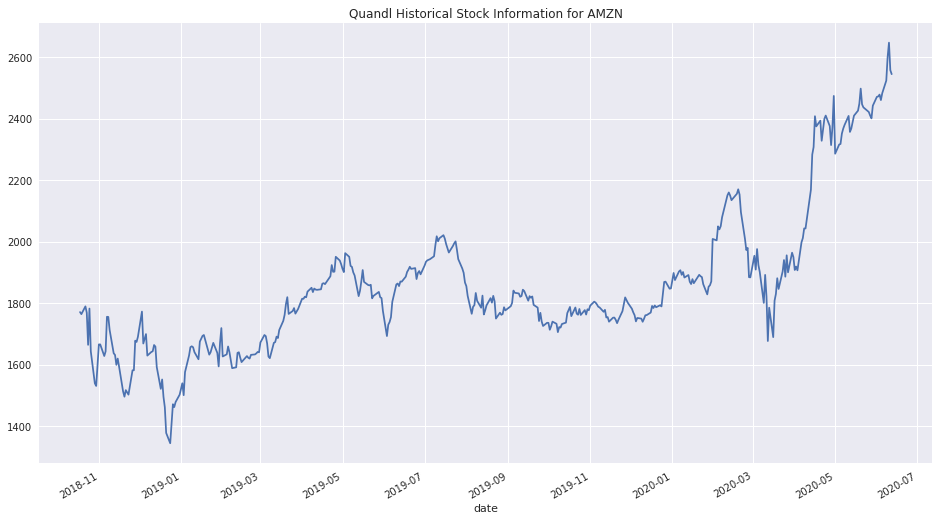

In [10]:
title_string = 'Quandl Historical Stock Information for ' + stock_symbol
stock_quandl['close'].plot(figsize=(16,9), title=title_string)
plt.show()

## Task 3. Develop Strategy and Train Model

### 3.a) Set up the Dataframe for the Trading Model

In [11]:
# Select the data source and pricing columns to use for modeling
# trading_model = stock_yahoo.loc[:, ['Open','Adj Close']]
# trading_model = stock_alpha.loc[:, ['open','adj_close']]
model_template = stock_quandl.loc[:, ['open','close']]
# trading_model = stock_quandl.loc[start_date:end_date, ['Adj_Close']]

# Set up the standard column name for modeling
model_template.rename(columns={'open': 'open_price', 'close': 'close_price'}, inplace=True)
if verbose: model_template.info(verbose=True)

In [12]:
if verbose: model_template.head()

In [13]:
if verbose: model_template.tail()

### 3.b) Set up the Analysis Table with Indicators

In [14]:
def trading_ma_crossover(model):
    waitfor_first_entry = True
    for x in range(len(model)):
        if model['ma_change'].iloc[x] > 0:
            model['trade_signal'].iloc[x] = 1  # trade_signal = 1 means we should take a long position
        else:
            model['trade_signal'].iloc[x] = 0  # trade_signal = 0 means we should take a flat position
        if x != 0:
            model['signal_change'].iloc[x] = model['trade_signal'].iloc[x] - model['trade_signal'].iloc[x-1]
            if waitfor_first_entry and (model['signal_change'].iloc[x-1] == 1):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]
                waitfor_first_entry = False
            elif (not waitfor_first_entry) and (model['signal_change'].iloc[x-1] != 0):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]
#     model['entry_exit'].iloc[-1] = -1  # the model assumes we will always exit at tht end of the modeling period

In [15]:
model_collection = {}
serial_number = 1

for slow_ma in range(slow_ma_min, slow_ma_max+1, ma_increment):
    for fast_ma in range(fast_ma_min, fast_ma_max+1, ma_increment):
        if (slow_ma - fast_ma) < min_ma_gap: break
        print('Processing model with slow_ma of', slow_ma, 'and fast_ma of', fast_ma)
        model_name = 'SMA_' + str(serial_number).zfill(3) + '_SlowMA_' + str(slow_ma).zfill(2) + '_FastMA_' + str(fast_ma).zfill(2)
        serial_number = serial_number + 1
        trading_model = model_template.copy()
        trading_model['fast_ma'] = trading_model['close_price'].rolling(fast_ma).mean()
        trading_model['slow_ma'] = trading_model['close_price'].rolling(slow_ma).mean()
        trading_model['ma_change'] = trading_model['fast_ma'] - trading_model['slow_ma']
        trading_model['trade_signal'] = np.zeros(len(trading_model))
        trading_model['signal_change'] = np.zeros(len(trading_model))
        trading_model['entry_exit'] = np.zeros(len(trading_model))
        trading_model = trading_model[model_start_date:model_end_date]
        trading_ma_crossover(trading_model)
        model_collection[model_name] = trading_model.copy()
        print('Model', model_name, 'added to the trading model collection.')

Processing model with slow_ma of 10 and fast_ma of 5
Model SMA_001_SlowMA_10_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 15 and fast_ma of 5
Model SMA_002_SlowMA_15_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 15 and fast_ma of 10
Model SMA_003_SlowMA_15_FastMA_10 added to the trading model collection.
Processing model with slow_ma of 20 and fast_ma of 5
Model SMA_004_SlowMA_20_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 20 and fast_ma of 10
Model SMA_005_SlowMA_20_FastMA_10 added to the trading model collection.
Processing model with slow_ma of 20 and fast_ma of 15
Model SMA_006_SlowMA_20_FastMA_15 added to the trading model collection.
Processing model with slow_ma of 25 and fast_ma of 5
Model SMA_007_SlowMA_25_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 25 and fast_ma of 10
Model SMA_008_SlowMA_25_FastMA_10 added to the trading model 

In [16]:
# List the entry/exit points for each model
for key in model_collection:
    print('List the signal change and entry/exit points for', key)
    if verbose: print(model_collection[key][(model_collection[key].signal_change != 0) | (model_collection[key].entry_exit != 0)])
    else: print(model_collection[key][model_collection[key].entry_exit != 0])
    print()

List the signal change and entry/exit points for SMA_001_SlowMA_10_FastMA_05
            open_price  close_price   fast_ma   slow_ma  ma_change  trade_signal  signal_change  entry_exit
date                                                                                                       
2019-02-05     1643.34      1658.81  1661.502  1650.480     11.022           1.0            0.0         1.0
2019-02-08     1586.00      1588.22  1626.994  1638.213    -11.219           0.0            0.0        -1.0
2019-02-20     1630.00      1622.10  1624.056  1619.214      4.842           1.0            0.0         1.0
2019-03-12     1669.00      1673.10  1651.884  1660.067     -8.183           0.0            0.0        -1.0
2019-03-18     1712.70      1742.15  1700.928  1678.339     22.589           1.0            0.0         1.0
2019-04-01     1800.11      1814.19  1783.564  1783.523      0.041           1.0            1.0        -1.0
2019-04-02     1811.02      1813.98  1789.608  1788.736    

In [17]:
if verbose:
    for key in model_collection:
        graph_data = model_collection[key].copy()
        title_string = "Simple Moving Average Crossover Model for " + key
        fig = plt.figure(figsize=(16,9))
        ylabel = stock_symbol + ' price in $'
        ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
        graph_data['fast_ma'].plot(ax=ax1, color='b', lw=2.)
        graph_data['slow_ma'].plot(ax=ax1, color='r', lw=2.)
        graph_data['close_price'].plot(ax=ax1, color='g')
        ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
        ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
        plt.legend(loc='upper left')
        plt.show()

## Task 4. Back-test Model

In [18]:
def trading_portfolio_generation(initial_fund, trading_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trading_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction', 'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
    portfolio.iloc[0]['trade_action'] = 0
    portfolio.iloc[0]['qty_onhand'] = 0
    portfolio.iloc[0]['cost_basis'] = 0.00
    portfolio.iloc[0]['sold_transaction'] = 0.00
    portfolio.iloc[0]['gain_loss'] = 0.00
    portfolio.iloc[0]['cash_onhand'] = initial_capital
    portfolio.iloc[0]['position_value'] = 0.00
    portfolio.iloc[0]['total_position'] = initial_capital
    portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - initial_fund
    recent_cost = 0

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        if (trading_model.iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
            portfolio.iloc[i]['trade_action'] = 1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
            recent_cost = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            if verbose: print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
        elif (trading_model.iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
            portfolio.iloc[i]['trade_action'] = -1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = 0.00
            portfolio.iloc[i]['sold_transaction'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
            portfolio.iloc[i]['gain_loss'] = (recent_cost + (trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
            recent_cost = 0.00
            if verbose: print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
        else:
            portfolio.iloc[i]['trade_action'] = 0
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
            portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
        portfolio.iloc[i]['position_value'] = trading_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
        portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
        portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - initial_fund

    return portfolio

In [19]:
portfolio_collection = {}

# Build dataframe for reporting model performance summary
performance_summary = pd.DataFrame(columns=['model_name','return_value','return_percent'])

for key in model_collection:
    print('Processing portfolio for model:', key)
    portfolio_collection[key] = trading_portfolio_generation(initial_capital, model_collection[key])
    trade_transactions = portfolio_collection[key][portfolio_collection[key].trade_action != 0]
    print(trade_transactions)
    print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (initial_capital, portfolio_collection[key].accumu_return[-1]))
    if initial_capital != 0:
        return_percentage = portfolio_collection[key].accumu_return[-1] / initial_capital * 100
        print('Accumulated return percentage based on the initial capital investment: %.2f%%' % (return_percentage))
    else:
        return_percentage = None
    if trade_transactions.iloc[-1]['trade_action'] == 1:
        print('The current status of the model is:', 'Holding a position since', trade_transactions.index.tolist()[-1], '\n')
    else:
        print('The current status of the model is:', 'Waiting to enter since', trade_transactions.index.tolist()[-1], '\n')
    performance_summary = performance_summary.append({'model_name': key, 'return_value': portfolio_collection[key].accumu_return[-1],
                                                      'return_percent': return_percentage}, ignore_index=True)

Processing portfolio for model: SMA_001_SlowMA_10_FastMA_05
           trade_action qty_onhand cost_basis sold_transaction gain_loss cash_onhand position_value total_position accumu_return
date                                                                                                                            
2019-02-05            1          1    1643.34                0         0    -1643.34        1658.81          15.47         15.47
2019-02-08           -1          0          0             1586    -57.34      -57.34              0         -57.34        -57.34
2019-02-20            1          1       1630                0         0    -1687.34         1622.1         -65.24        -65.24
2019-03-12           -1          0          0             1669        39      -18.34              0         -18.34        -18.34
2019-03-18            1          1     1712.7                0         0    -1731.04        1742.15          11.11         11.11
2019-04-01           -1          0   

In [20]:
# Display the model performance summary
performance_summary.sort_values(by=['return_value'], inplace=True, ascending=False)
print(performance_summary)

                     model_name  return_value return_percent
11  SMA_012_SlowMA_30_FastMA_10        839.07           None
0   SMA_001_SlowMA_10_FastMA_05        770.62           None
1   SMA_002_SlowMA_15_FastMA_05        759.50           None
26  SMA_027_SlowMA_50_FastMA_05        733.30           None
14  SMA_015_SlowMA_35_FastMA_05        712.23           None
22  SMA_023_SlowMA_45_FastMA_05        677.11           None
18  SMA_019_SlowMA_40_FastMA_05        658.79           None
2   SMA_003_SlowMA_15_FastMA_10        622.61           None
10  SMA_011_SlowMA_30_FastMA_05        591.93           None
7   SMA_008_SlowMA_25_FastMA_10        584.35           None
15  SMA_016_SlowMA_35_FastMA_10        562.33           None
4   SMA_005_SlowMA_20_FastMA_10        529.20           None
23  SMA_024_SlowMA_45_FastMA_10        528.31           None
8   SMA_009_SlowMA_25_FastMA_15        517.12           None
12  SMA_013_SlowMA_30_FastMA_15        492.31           None
6   SMA_007_SlowMA_25_Fa

In [21]:
# Display the transactions from the top model
top_model = performance_summary.iloc[0]['model_name']
print('The transactions from the top model %s:' % (top_model))
print(portfolio_collection[top_model][portfolio_collection[top_model].trade_action != 0])

The transactions from the top model SMA_012_SlowMA_30_FastMA_10:
           trade_action qty_onhand cost_basis sold_transaction gain_loss cash_onhand position_value total_position accumu_return
date                                                                                                                            
2019-01-15            1          1       1632                0         0       -1632        1674.56          42.56         42.56
2019-02-14           -1          0          0           1624.5      -7.5        -7.5              0           -7.5          -7.5
2019-03-05            1          1    1702.95                0         0    -1710.45        1692.43         -18.02        -18.02
2019-05-21           -1          0          0          1874.79    171.84      164.34              0         164.34        164.34
2019-06-20            1          1    1933.33                0         0    -1768.99        1918.19          149.2         149.2
2019-08-02           -1         

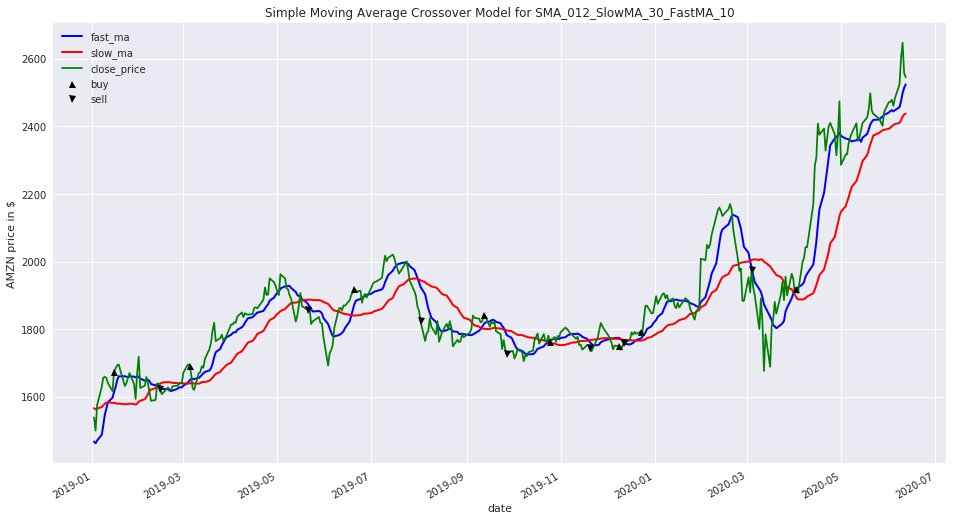

In [22]:
graph_data = model_collection[top_model].copy()
title_string = "Simple Moving Average Crossover Model for " + top_model
fig = plt.figure(figsize=(16,9))
ylabel = stock_symbol + ' price in $'
ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
graph_data['fast_ma'].plot(ax=ax1, color='b', lw=2.)
graph_data['slow_ma'].plot(ax=ax1, color='r', lw=2.)
graph_data['close_price'].plot(ax=ax1, color='g')
ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
plt.legend(loc='upper left')
plt.show()

## Task 5. Evaluate Performance

In [23]:
best_model = ''
best_return = 0
for key in portfolio_collection:
    if portfolio_collection[key]['accumu_return'][-1] > best_return:
        best_model = key
        best_return = portfolio_collection[best_model]['accumu_return'][-1]
print('The best model found is:', best_model)
print('The best profit/loss for the investing period is: $%.2f' % (best_return))
if initial_capital != 0:
    print('The best return percentage for initial capital is: %.2f%%' % (best_return / initial_capital * 100))

The best model found is: SMA_012_SlowMA_30_FastMA_10
The best profit/loss for the investing period is: $839.07


In [24]:
worst_model = None
worst_return = 0
for key in portfolio_collection:
    if portfolio_collection[key]['accumu_return'][-1] < worst_return:
        worst_model = key
        worst_return = portfolio_collection[worst_model]['accumu_return'][-1]
print('The worst model found is:', worst_model)
print('The worst profit/loss for the investing period is: $%.2f' % (worst_return))
if initial_capital != 0:
    print('The worst return percentage for the initial capital is: %.2f%%' % (worst_return / initial_capital * 100))

The worst model found is: SMA_026_SlowMA_45_FastMA_20
The worst profit/loss for the investing period is: $-198.37


In [25]:
# Calculate the stock's performance for a long-only model
model_template = model_template[model_start_date:model_end_date]
print('The performance of the long-only model from day one is: $%.2f' %(model_template.iloc[-1]['close_price'] - model_template.iloc[0]['open_price']))

The performance of the long-only model from day one is: $1079.82


In [26]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:01:19.653864
